# Choose whether to ignore warnings

In [1]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

# Load data

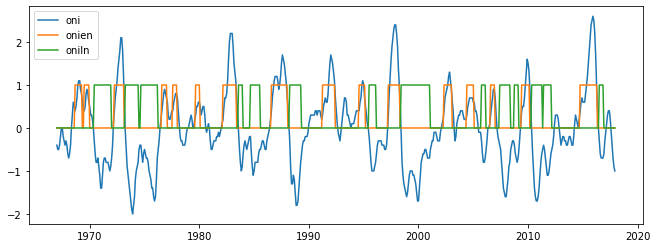

In [2]:
%run wcpfc_load_and_calc.ipynb

# Extra things to load

In [3]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
import scipy.stats as stats

In [4]:
lon = wf['lon']
lat = wf['lat']

# Load WOD18 data

In [5]:
# Load o2, temp, sal from WOD18 nc files (already on good grid)
# -->Get SST, O2100, SSS
# -->Compute THD, TCD, O2100INT, T100INT

In [6]:
ncfile = dpath + 'WOD18/o2_195501-201807_5deg.nc'
o2 = xr.open_dataset(ncfile)
ncfile = dpath + 'WOD18/sal_195501-201807_5deg.nc'
sal = xr.open_dataset(ncfile)
ncfile = dpath + 'WOD18/temp_195501-201807_5deg.nc'
temp = xr.open_dataset(ncfile)

### Correct the time axis

In [7]:
# - Time goes from Jan 1955 - Jul 2018 --> 763 months
begdatewod = datetime.date(year = 1955, month = 1, day = 1)
enddatewod = datetime.date(year = 2018, month = 7, day = 1)
timemowod = pd.date_range(begdatewod, enddatewod, freq='MS')

In [8]:
o2['time'] = timemowod
sal['time'] = timemowod
temp['time'] = timemowod

In [9]:
sst = temp['Temp'].isel(depth=0)
o2100 = o2['O2'].sel(depth=100)
sss = sal['Sal'].isel(depth=0)

### Change from -180-180 to 0-360 lon

In [10]:
# https://github.com/pydata/xarray/issues/577 - wrap 0 to 360
# https://github.com/pydata/xarray/issues/1875 - roll
sst['lon'] = np.mod(sst['lon'], 360)
sst = sst.reindex({'lon': np.sort(sst['lon'])}) # or: sst = sst.roll(lon=36)
o2100['lon'] = np.mod(o2100['lon'], 360)
o2100 = o2100.reindex({'lon': np.sort(o2100['lon'])}) # or: o2100 = o2100.roll(lon=36)
sss['lon'] = np.mod(sss['lon'], 360)
sss = sss.reindex({'lon': np.sort(sss['lon'])}) # or: sss = sss.roll(lon=36)

# Load chl data

In [11]:
# (need to regrid to WCPFC grid OR use already matlab regridded files)

# Load MLD data

In [12]:
# Download MLD from reanalysis

# Load SSHA data

In [13]:
# (need to regrid to WCPFC grid OR use already matlab regridded files)

# Load wind speed or Lyapunov data

In [14]:
# (need to regrid to WCPFC grid OR use already matlab regridded files)

# Reproduce quotient analysis from R

In [15]:
dfr = pd.read_csv(dpath+'Rtestdata/cufessurv.csv');
dfr.drop(dfr.columns[0],axis=1,inplace=True)
dfr.head(2)

,Date,Times,Timee,Time,Duration,Flow,Lats,Longs,Late,Longe,...,Sardens,Ancdens,Temp,Sal,Dist,Cas.lat,Cas.long,Depth,Logdepth,Sarpres
0,20000327,5.390833,5.569444,5.480139,0.178611,5.894167,41.960278,9.040278,41.958889,9.009444,...,0.0,0.0,13.98,35.537,8.888460,41.9524,-8.9178,90.5,4.50535,0
1,20000327,5.826111,5.897500,5.861806,0.071389,2.355833,41.952500,9.006667,41.953333,9.005833,...,0.0,0.0,13.98,35.537,7.314603,41.9524,-8.9178,86.3,4.45783,0


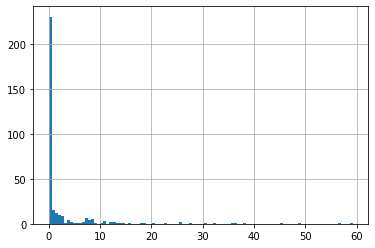

In [16]:
myvar = dfr['Sardens']
by = dfr['Temp']
myvar.hist(bins=100)

In [17]:
# --> i like this
#inter = 0.25
#breaklist = np.arange(by.min()-inter/2, by.max()+inter/2, inter)

In [62]:
def quotient_analysis(dfr):
    breaklist = np.arange(11.8,14.6,0.2)
    dfr['Temp_bin']=pd.cut(dfr['Temp'],breaklist)
    varcounts=dfr.groupby('Temp_bin')['Temp'].count()
    myvarcounts=dfr.groupby('Temp_bin')['Sardens'].sum()
    varfreq = varcounts*100/varcounts.sum()
    myvarfreq = myvarcounts*100/myvarcounts.sum()
    myvarquot = myvarfreq/varfreq
    return myvarquot 

In [39]:
nruns = 399
dfsim = pd.DataFrame()

In [40]:
for i in range(nruns):
    dfsim=pd.concat([dfsim,myvar.sample(n=len(myvar), replace=False).reset_index(drop=True)], axis=1)

In [47]:
dfsim = pd.concat([dfsim,by],axis=1)

In [54]:
dfsim.head()

,Sardens,Sardens,Sardens,Sardens,Sardens,Sardens,Sardens,Sardens,Sardens,Sardens,...,Sardens,Sardens,Sardens,Sardens,Sardens,Sardens,Sardens,Sardens,Sardens,Temp
0,0.000000,0.000000,0.000000,7.813674,0.0,8.272296,0.000000,7.631874,0.000000,0.000000,...,0.000000,14.335664,0.000000,2.417921,0.000000,0.000000,0.000000,0.000000,0.412832,13.98
1,0.000000,23.052809,10.389610,13.479624,0.0,1.380898,0.566706,1.638705,0.000000,1.657324,...,0.157722,0.369800,0.000000,0.000000,0.000000,2.734469,0.000000,3.755115,0.212033,13.98
2,0.000000,0.000000,2.734469,7.533903,0.0,0.000000,0.000000,0.000000,2.179524,8.779298,...,0.000000,0.000000,1.598402,0.000000,1.068566,0.000000,2.488766,1.197704,8.279720,13.98
3,2.417921,0.000000,0.000000,0.000000,0.0,0.903614,0.000000,2.493015,0.000000,0.000000,...,0.000000,0.000000,1.067774,0.000000,0.000000,0.000000,15.824176,2.828283,0.205251,13.98
4,59.259259,7.369375,8.855729,0.298879,0.0,1.909091,8.779298,0.000000,0.000000,0.000000,...,0.000000,0.000000,12.851023,0.000000,45.446522,1.784933,0.000000,0.000000,0.000000,13.98


In [77]:
out = pd.DataFrame()
for i in range(nruns):
    out = pd.concat([out,quotient_analysis(dfsim.iloc[:,[i,-1]])], axis=1)

In [80]:
out

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(11.8, 12.0]",1.516902,0.000000,0.118530,0.435737,0.632450,0.133233,0.375910,0.196571,0.874829,0.073157,...,0.366780,0.000000,0.000000,0.171515,5.038519,0.240699,0.315544,0.092458,0.025917,3.107207
"(12.0, 12.2]",1.308398,0.659360,0.385641,0.531414,0.327739,0.425438,0.474688,0.291368,1.010494,1.260035,...,0.720194,1.446002,1.199330,0.402933,1.224292,0.758426,1.232002,2.351446,0.226170,0.535772
"(12.2, 12.4]",1.166637,1.104615,1.029030,0.537643,0.925373,1.020590,0.761481,1.267578,0.856512,1.179023,...,0.788397,0.885524,0.710893,0.880359,1.332708,1.003916,0.864451,0.621876,1.228232,1.313257
"(12.4, 12.6]",0.840258,1.470703,0.602475,0.863973,1.184391,1.259665,1.243162,0.761339,1.086601,0.907034,...,0.998103,0.878914,0.967669,0.678325,1.254520,0.542259,0.734848,1.232686,0.994081,1.056575
"(12.6, 12.8]",0.243752,1.357326,2.937899,1.160590,0.826073,0.442986,1.840469,0.308725,1.070632,0.176849,...,1.617196,0.852488,0.541494,1.893647,0.329836,1.590304,0.779153,0.445506,1.864978,0.397971
"(12.8, 13.0]",1.704781,0.524988,1.587800,1.731396,1.545517,0.904445,0.154564,1.856630,2.185907,1.663906,...,1.115588,0.242621,1.019571,0.420690,0.508090,0.687185,1.555200,2.198157,1.051550,1.248555
"(13.0, 13.2]",1.083610,0.891756,0.257247,0.394842,0.630598,1.597814,1.006845,1.234154,0.025399,1.245828,...,0.200339,0.280297,0.282166,0.847665,0.192778,0.022196,0.647685,0.173447,0.511489,1.795533
"(13.2, 13.4]",0.571531,0.604439,1.090702,1.961396,1.364106,1.501795,0.189047,0.589888,0.613503,0.426171,...,0.907182,0.819913,2.528712,2.247593,1.080672,1.744918,1.312471,0.967620,0.887731,0.241119
"(13.4, 13.6]",0.441443,0.815990,0.291449,1.412606,0.202213,0.974542,1.491566,1.131498,0.485472,1.150713,...,1.317080,1.782992,0.536731,0.287439,0.787449,1.025784,1.558212,1.415865,1.072020,0.886075
"(13.6, 13.8]",0.793513,0.675124,1.161349,1.407031,1.076774,0.853226,1.745405,0.859231,1.941690,1.093982,...,1.430633,1.523806,1.840918,1.214569,0.192546,1.352458,1.215337,0.755225,0.773644,0.487903


In [83]:
qlims = out.quantile([0.025, 0.975], axis=1)
qlims

,"(11.8, 12.0]","(12.0, 12.2]","(12.2, 12.4]","(12.4, 12.6]","(12.6, 12.8]","(12.8, 13.0]","(13.0, 13.2]","(13.2, 13.4]","(13.4, 13.6]","(13.6, 13.8]","(13.8, 14.0]","(14.0, 14.2]","(14.2, 14.4]"
0.025,0.00000,0.100657,0.539298,0.523315,0.023207,0.128441,0.052745,0.121247,0.263988,0.264488,0.098663,0.026922,0.000000
0.975,6.34781,2.529425,1.522454,1.750323,2.953668,2.372181,2.450850,2.530891,2.129263,2.143455,2.326684,3.777580,4.414878


In [96]:
meanbreak = (breaklist[1:] + breaklist[:-1])/2

In [99]:
meanbreak.size

13

In [113]:
qlims.iloc[0]

(11.8, 12.0]    0.000000
(12.0, 12.2]    0.100657
(12.2, 12.4]    0.539298
(12.4, 12.6]    0.523315
(12.6, 12.8]    0.023207
(12.8, 13.0]    0.128441
(13.0, 13.2]    0.052745
(13.2, 13.4]    0.121247
(13.4, 13.6]    0.263988
(13.6, 13.8]    0.264488
(13.8, 14.0]    0.098663
(14.0, 14.2]    0.026922
(14.2, 14.4]    0.000000
Name: 0.025, dtype: float64

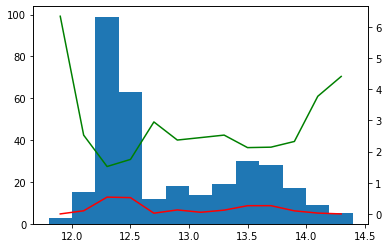

In [124]:
ax = plt.subplot(1, 1, 1)
ax.hist(by, bins=breaklist)
ax1 = ax.twinx()
ax1 # continue here!!!!!!!!!
ax1.plot(meanbreak,qlims.iloc[0],'r')
ax1.plot(meanbreak,qlims.iloc[1],'g')

In [ ]:
varcounts, _, _ = plt.hist(by, bins=breaklist)

# Question 3a from 9/19/19 in written lab notebook

In [ ]:
sstnow = sst.where(skj_cp_tot.notnull())

In [ ]:
fig,axes=plt.subplots(figsize=(8,2),nrows=1,ncols=2)
sst.plot.hist(ax=axes[0],bins=20);
sstnow.plot.hist(ax=axes[1],bins=20);

# Notes